# LeNet网络
## LeNet网络介绍

LeNet，它是最早发布的卷积神经网络之一，因其在**计算机视觉任务**中的高效性能而受到广泛关注。
当初目的是识别图像 (LeCun et al., 1998)中的手写数字。
LeNet取得了与支持向量机SVM性能相媲美的成果，成为监督学习的主流方法。
eNet被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。

输入为1\*1\*32\*32

第一层：C1 feature map 5\*5的卷积层，6个输出通道，输出为6通道，输出为6\*28\*28

第二层：S2 feature map 2\*2的池化层，步幅为2，输出为6\*14\*14

第三层：C3 feature map 5\*5的卷积层，6个输入通道，输出为16道，输出为16\*10\*10

第四层：S4 feature map 2\*2的池化层，步幅为2，输出为16\*5\*5

拉长为一个长向量400，两层全连接分别将为120，84，最后一个高斯层（现在消失了），输出为10

**理解为两个卷积层+SVM完成的**
现在的神经网络多数方式都是压缩高宽，最后不断增加通道数，达到要求


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10))# 此处第一层padding=2的原因是我的输入是28*28，变成32*32之后执行LeNet，每一次加了激活函数sigmod

可以参考这个代码，以后写深度网络如果想知道每一层的具体构架可以使用这个方法

In [4]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## 训练

In [5]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=256);

In [6]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #此函数d2l.torch库中本身就有，但我们需要熟悉函数逻辑
    """使用GPU计算模型在数据集（测试集）上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device #寻找你原本net网络设置时第一层参数存放的设备
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2) #设置一个迭代器，里面存放两列一一对应的数据对
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())# accuracy计算的是分类问题中正确预测的总数
    return metric[0] / metric[1] #算平均数

In [7]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device): #此函数d2l.torch库中本身就有，但我们需要熟悉函数逻辑，这是后面深度学习中最常见的代码
    """用GPU训练模型(在第六章定义)，模型使用SGD，损失函数是交叉熵，为了调参改为Adam"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)# 此处把整个网络移动过去，evaluate_accuracy_gpu是为了测试集而存在的，将测试集的X，y移动过去
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)# 训练损失之和，训练准确率之和，样本数
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #训练集的数据移动到device上
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))# 此处是为了显示图像更方便，拆分等分显示图片
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.232, train acc 0.912, test acc 0.897
63069.2 examples/sec on cuda:0


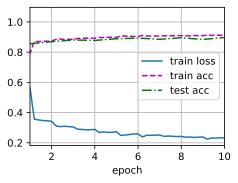

In [8]:
lr, num_epochs = 0.01, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, device='cuda:0')

调参记录：

1.   **直接使用Adam优化器**：结果并不理想。

 -  GPT的回答：Adam更适合那些需要快速收敛、处理复杂模型或处理含有稀疏数据的场景。SGD更适合于那些对学习过程的精细控制非常重要的场景，或者在一些数据和模型较为简单的任务中。
2.   一般卷积神经网络很难出现过拟合的情况，故此处不需要加权重衰退或者dropout。
3.   增加了epoch次数，但是下降依旧不明显，说明已经走到了极值附近。
4.   **尝试换成Rule激活函数**：发现拟合速度完全不动。
 *   评论区的解释：因为学习率太大了，lr换成0.01或者用Adam会有一个显著的提升，学习率过大导致参数一直在目标附近来回震荡而落不下去。把lr调小就可以很快收敛，0.9这个学习率对于ReLU来说太大了。**可能是因为ReLU在0的右邻域内的梯度比sigmoid大得多，所以适用于sigmoid的lr用在ReLU身上容易步子迈太大，走过头，反而不好收敛。**
5.   **激活函数换为Rule+ lr=0.01**：后发现从第6次迭代才开始明显收敛。
6.   **Rule函数+ lr=0.01+ Adam**：*Adam可以加快收敛速度*，最终结果很不错，**训练准确率提高到0.9以上**
7.   **Rule函数+ lr=0.01+ Adam+ MaxPooling：** 最终结果很不错，**训练准确率提高到0.9以上**，与6区别不大。
 -   **关于最大池化层和平均池化层**：gpt回答：Max Pooling通过提取区域的极值来*保留显著特征*，通常对*噪声和异常值具有较强的鲁棒性*。而 Average Pooling 通过*计算平均值来提供更平滑的特征表示*，可以*减少过拟合*的风险。
 -   为了识别衣服的特征，我们需要强调显著特征，故更换为MaxPooling

## 其他网友扩展

原模型是全程使用5\*5卷积核，这位网友使用的是先5\*5后面转为3\*3更细致，通道数也显著升高了，但是展平后维数并没有显著增加。展平后全连接层也多增加了一层。

依旧使用**Rule函数+ lr=0.01+ Adam**，增加到20次迭代

In [9]:
changed_net = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=5, padding=2), nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),# nn.MaxPool2d(kernel_size=2，stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),# nn.MaxPool2d(kernel_size=2，stride=2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2), # nn.MaxPool2d(kernel_size=2，stride=2),
        nn.Flatten(),
        nn.Linear(32 * 3 * 3, 128), nn.ReLU(),
        nn.Linear(128, 64), nn.ReLU(),
        nn.Linear(64, 32), nn.ReLU(),
        nn.Linear(32, 10))
changed_net

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=288, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): Linear(in_features=64, out_features=32, bias=True)
  (15): ReLU()
  (16): Linear(in_features=32, out_features=10, bias=True)
)

loss 0.204, train acc 0.924, test acc 0.903
59369.8 examples/sec on cuda:0


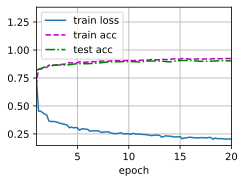

In [10]:
lr, num_epochs = 0.01, 20
train_ch6(changed_net, train_iter, test_iter, num_epochs, lr, device='cuda:0')

In [11]:
def predict(net, change_net, test_iter, n=12):  # 预测标签
    for X, y in test_iter:
      X = X.cuda()
      y = y.cuda()
      break #这里使用了break是因为只取了一个批次的数据，因为接下来的操作是对只针对这个批次的数据
    net = net.cuda()
    changed_net = change_net.cuda()
    trues = d2l.get_fashion_mnist_labels(y)
    preds_net = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    preds_changed_net = d2l.get_fashion_mnist_labels(changed_net(X).argmax(axis=1))
    titles = [true +'\n' + pred_net +'\n' + preds_changed_net for true, pred_net, preds_changed_net in zip(trues, preds_net, preds_changed_net)]
    X_cpu = X.cpu()
    #存储在GPU上的张量直接转换为NumPy数组，这是不允许的。NumPy无法直接处理存储在GPU上的数据
    d2l.show_images(
        X_cpu[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

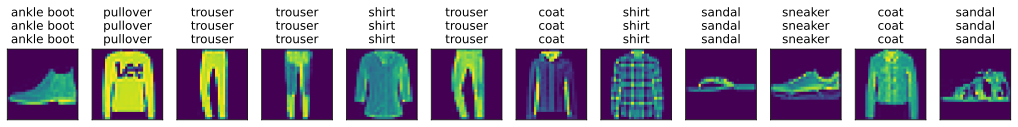

In [12]:
predict(net, changed_net, test_iter)

QA:
1.  一般宽高减去一半，通道数会增加一倍。
2.  Rule函数在0点处梯度更大，MaxPooling数更大，这些都间接加快了拟合速度。

